In [1]:
from utils.misc import *
from train.train import Train,Test
from datasets.data_utils import load_dataset
from model.Creat_model import creat_model
from utils.preprocess import *
from utils.utils import *

2025-03-31 15:08:20.715901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 15:08:21.222362: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-31 15:08:23.600050: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2025-03-31 15:08:23.600209: W tensorflow/compiler/xla/stream_executor/p

In [2]:
from torch.backends import cudnn
def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   

In [3]:
import networkx
import torch
import scipy.sparse as sp
import numpy as np
import os
import random
from munkres import Munkres
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import argparse
import yaml
from torch_geometric.utils.convert import to_networkx
import pynvml

def build_args():
    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', type=str, default="acm")
    parser.add_argument('--seed', type=int, default=20)
    parser.add_argument('--cuda', type=bool, default=True)
    parser.add_argument('--n_input', type=int, default=None)
    parser.add_argument('--n_z', type=int, default=None)
    parser.add_argument('--freedom_degree', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=None)
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--sigma', type=float, default=None)
    parser.add_argument('--loss_n', type=float, default=None)
    parser.add_argument('--loss_w', type=float, default=None)
    parser.add_argument('--loss_s', type=float, default=None)
    parser.add_argument('--loss_a', type=float, default=None)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--acc', type=float, default=-1)
    parser.add_argument('--f1', type=float, default=-1)
    args = parser.parse_args([])
    return args

In [4]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps)
    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

def clr_normalize_each_cell(adata, inplace=True):
    
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()
    
    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata     

In [5]:
args = build_args()
args = load_configs(args, "config/configs.yml")
# set_random_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load configs


In [6]:
# read data
import scanpy as sc
file_fold = '/home/hfzhang/data/空间转录组/Mouse_Thymus/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
labels=sc.read_h5ad('/home/hfzhang/data/空间转录组/Mouse_Thymus/adata_thymus1_annotation.h5ad')
adata_omics1.obs['final_annot'] = labels.obs['Annotation'].reindex(adata_omics1.obs.index)  
adata_omics2.obs['final_annot'] = labels.obs['Annotation'].reindex(adata_omics2.obs.index) 
adata_omics1 = adata_omics1[adata_omics1.obs['final_annot'].notna()]  
adata_omics2 = adata_omics2[adata_omics2.obs['final_annot'].notna()]  

In [7]:
labels

AnnData object with n_obs × n_vars = 4468 × 15690
    obs: 'orig.ident', 'x', 'y', 'n_genes', 'mclust', 'label_new', 'label_origi', 'RNA_label_origi', 'Pro_label_origi', 'RNA_label_new', 'Pro_label_new', 'label_new_combined', 'SpatialGlue', 'MEFISTO', 'MOFA', 'Seurat', 'StabMap', 'MultiVI', 'totalVI', 'scMM', 'Annotation'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Annotation_colors', 'MEFISTO_colors', 'MOFA_colors', 'MultiVI_colors', 'Seurat_colors', 'SpatialGlue_colors', 'StabMap_colors', 'adj', 'hvg', 'label_new_colors', 'label_new_combined_colors', 'label_origi_colors', 'leiden', 'log1p', 'neighbors', 'scMM_colors', 'totalVI_colors', 'umap'
    obsm: 'Pro_feat', 'Pro_feat_pca', 'Pro_latent', 'Pro_latent_pca', 'RNA_feat', 'RNA_feat_pca', 'RNA_latent', 'RNA_latent_pca', 'X_StabMap', 'X_umap', 'alpha', 'alpha_omics_1', 'alpha_omics_2', 'emb', 'emb_combined', 'emb_combined_pca', 'emb_pca', 'feat', 'graph_feat', 'origi_

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


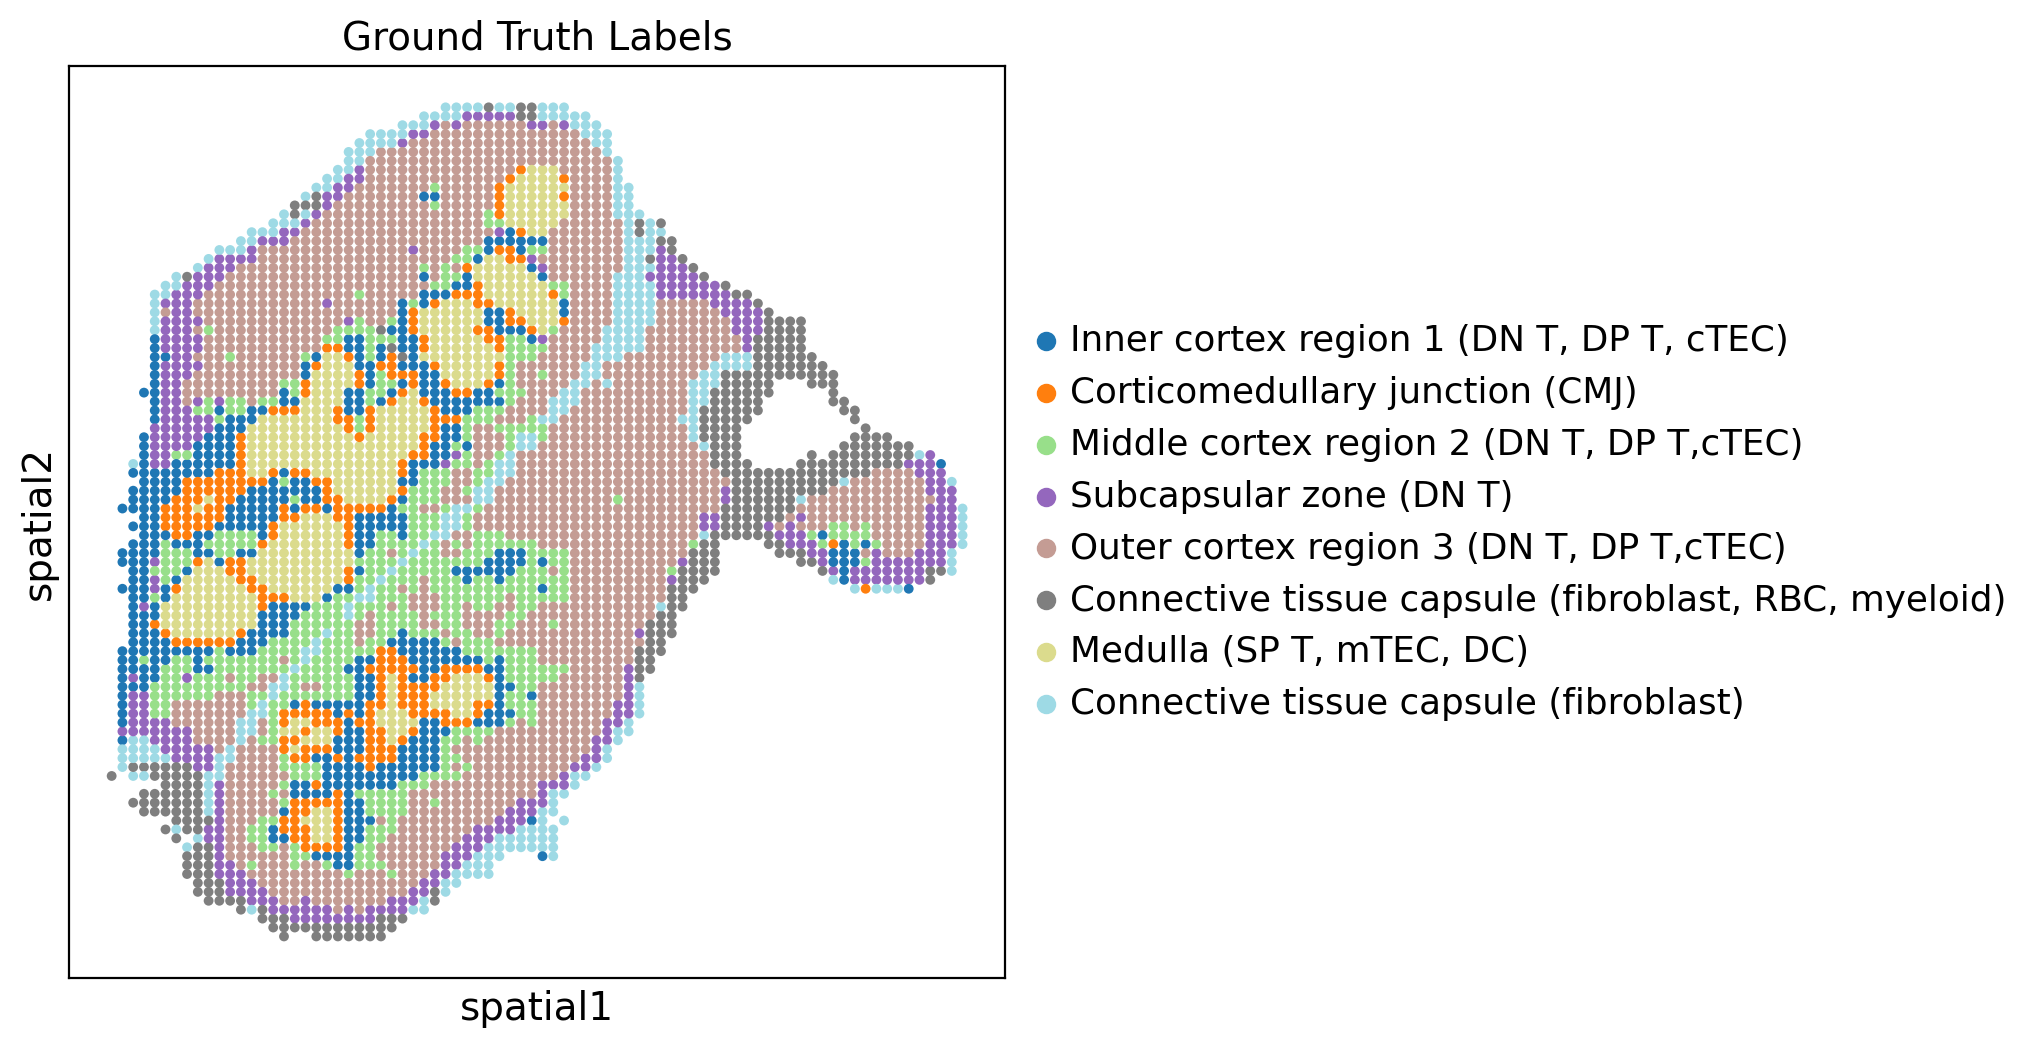

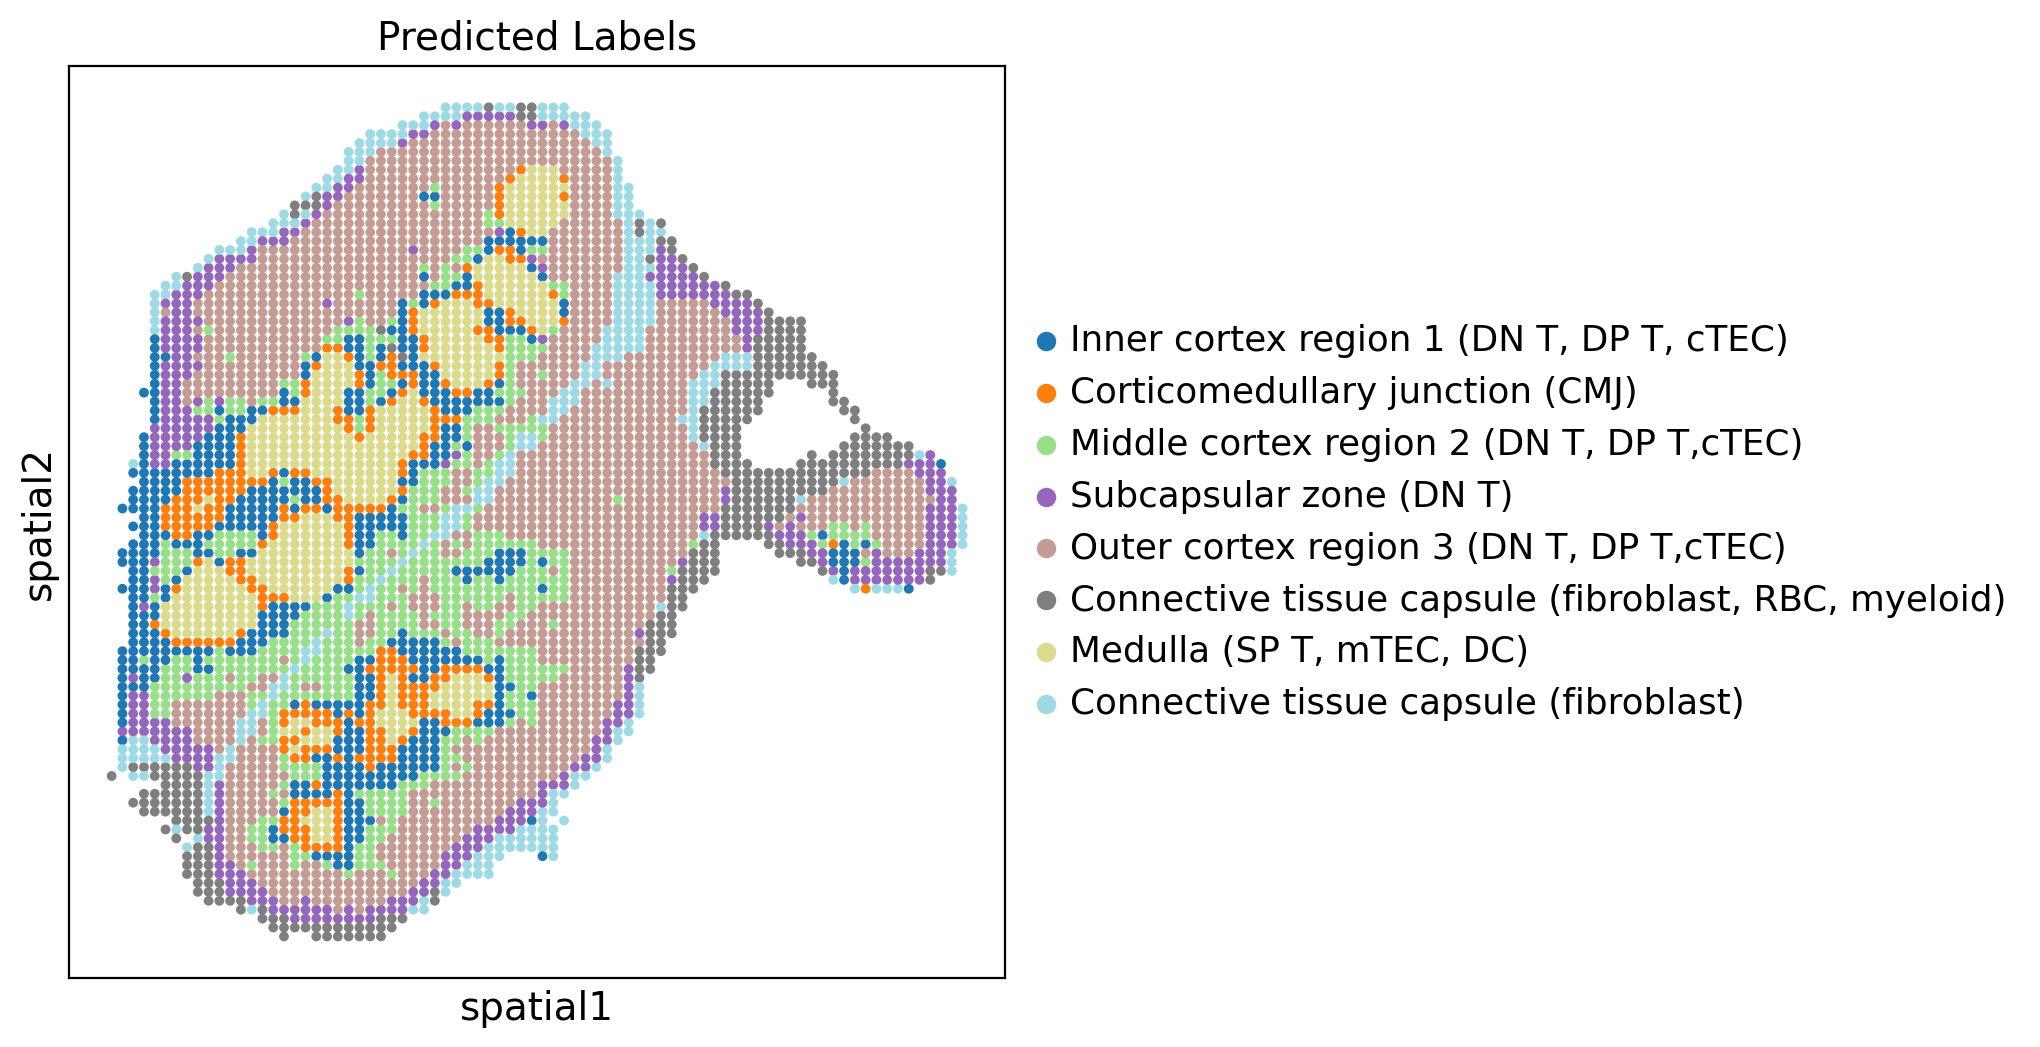

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt

# 假设你已经有一个 AnnData 对象 adata_omics1_train
# adata_omics1_train 包含降维后的嵌入（例如 UMAP 或 t-SNE）和 obs 中的 ground_truth 和 pred 列

# 1. 检查 AnnData 对象
# print(adata_omics1_train)

# 2. 设置绘图参数
sc.set_figure_params(figsize=(6, 6), dpi=100)

# 3. 绘制真实标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='final_annot',  # 使用 obs 中的 ground_truth 列作为颜色
    title='Ground Truth Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=50,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 4. 绘制预测标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='final_annot',  # 使用 obs 中的 pred 列作为颜色
    title='Predicted Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=50,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 5. 显示图像
plt.show()

In [9]:
labels.obs

orig.ident     x      y  n_genes mclust label_new label_origi  \
0_22     sample  8919  13270      174      7         6           5   
0_33     sample  8919  14370     1573      1         1           8   
0_40     sample  8919  15070     2327      3         4           8   
0_41     sample  8919  15170     1353      3         3           6   
0_42     sample  8919  15270     1590      1         3           1   
...         ...   ...    ...      ...    ...       ...         ...   
9_73     sample  9819  18370     1230      1         1           8   
9_74     sample  9819  18470      451      4         5           3   
9_75     sample  9819  18570     1840      1         3           1   
9_8      sample  9819  11870      251      6         2           3   
9_9      sample  9819  11970     1126      1         1           1   

     RNA_label_origi Pro_label_origi RNA_label_new  ... label_new_combined  \
0_22               5               6             6  ...                  7   
0_33               8               7             1  ...                  1   
0_40               8               1             4  ...                  3   
0_41               6               1             3  ...                  3   
0_42               1               1             3  ...                  1   
...              ...             ...           ...  ...                ...   
9_73               8               1             1  ...                  1   
9_74               3               4             5  ...                  4   
9_75               1               1             3  ...                  1   
9_8                3               1             2  ...                  6   
9_9                1               1             1  ...                  1   

     SpatialGlue MEFISTO MOFA Seurat StabMap MultiVI totalVI scMM  \
0_22           7       6    7      4       7       4       3    3   
0_33           1       5    8      0       0       0       4    4   
0_40           3       4    8      0       0       0       4    4   
0_41           3       8    8      0       0     NaN       1    4   
0_42           1       4    6      0       0       3       1    4   
...          ...     ...  ...    ...     ...     ...     ...  ...   
9_73           1       5    8      0       0       0       4    4   
9_74           4       3    6      1       4       1       6    2   
9_75           1       5    8      6       0       0       1    4   
9_8            6       6    7      5       0       4       5    8   
9_9            1       8    8      0       0       2       4    4   

                                             Annotation  
0_22  Connective tissue capsule (fibroblast, RBC, my...  
0_33            Outer cortex region 3 (DN T, DP T,cTEC)  
0_40           Middle cortex region 2 (DN T, DP T,cTEC)  
0_41           Middle cortex region 2 (DN T, DP T,cTEC)  
0_42            Outer cortex region 3 (DN T, DP T,cTEC)  
...                                                 ...  
9_73            Outer cortex region 3 (DN T, DP T,cTEC)  
9_74                    Corticomedullary junction (CMJ)  
9_75            Outer cortex region 3 (DN T, DP T,cTEC)  
9_8              Connective tissue capsule (fibroblast)  
9_9             Outer cortex region 3 (DN T, DP T,cTEC)  

[4468 rows x 21 columns]

In [10]:

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1 =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1, n_comps=adata_omics2.n_vars-1)
# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

/tmp/ipykernel_17300/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_17300/529664883.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_17300/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_17300/529664883.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr 

In [11]:
def create_adj(adata):
    cell_position_omics1 = adata.obsm['spatial']
    adj_omics1 = construct_graph_by_coordinate(cell_position_omics1, n_neighbors=3)
    adata.uns['adj_spatial'] = adj_omics1
    adj_spatial_omics1 = adata.uns['adj_spatial']
    adj_spatial_omics1 = transform_adjacent_matrix(adj_spatial_omics1)
    adj_spatial_omics1 = adj_spatial_omics1.toarray()
    adj_spatial_omics1 = adj_spatial_omics1 + adj_spatial_omics1.T
    adj_spatial_omics1 = np.where(adj_spatial_omics1>1, 1, adj_spatial_omics1)
    adj = preprocess_graph(adj_spatial_omics1)
    return adj

In [12]:
label=adata_omics2.obs['final_annot'].values
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [31]:
args.n_input=adata_omics2.n_vars-1
args.n_input1=adata_omics2.n_vars-1
args.n_clusters=len(classes)
device='cuda:1'
args.n_clusters
random_seek=2024
args.random_seed=random_seek
args.Type='Stereo-CITE-seq'
# args.name='Human_tonsil2'
if args.Type == 'Spots':
    args.epoch=200
    args.loss_n=0.01
elif args.Type == '10x':
    args.loss_n=0.001
    args.epoch=300
elif args.Type == 'Stereo-CITE-seq':
    args.loss_n=0.001
    args.epoch=500
elif args.Type == 'humanplacenta':
    args.loss_n=0.01
    args.epoch=300
args.n_clusters=len(classes)

In [32]:
fix_seed(random_seek)

In [15]:
args.loss_n

0.001

In [21]:
loss_n=0.001
loss_s=0.1
loss_w=0.1
lr=0.0001

In [16]:
# args.epoch=500
# args.ln=0.001
# args.lr=0.001

In [33]:
# adata_omics1_train, adata_omics2_train = adata_omics1, adata_omics1
# adata_omics2_train,adata_omics2_test =adata_omics2, adata_omics2
# label_train,label_test=label,label
args.n_clusters1=len(set(label))
args.n_clusters2=len(set(label))
adj_train=create_adj(adata_omics1)
# adj_test=create_adj(adata_omics1_test)
adj_train = adj_train.to(device)
# adj_test = adj_test.to(device)
features_omics1 = torch.FloatTensor(adata_omics1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata_omics2.obsm['feat'].copy()).to(device)
# features_omics1_test = torch.FloatTensor(adata_omics1_test.obsm['feat'].copy()).to(device)
# features_omics2_test = torch.FloatTensor(adata_omics2_test.obsm['feat'].copy()).to(device)

model = creat_model('spamgcn', args).to(device)
# model=preTrain(200, model, features_omics1_train,features_omics2_train, adj_train, label_train, device, args)
model=Train(50, model, features_omics1,features_omics2, adj_train, label, device, args)
nmi, ari, ami, homogeneity, completeness, v_measure=Test(model,adata_omics1,features_omics1,features_omics2,adj_train,label,device,args,'kmeans')
# adata_omics1.write_h5ad('/home/hfzhang/workplace/compare/spaMGCN-main/MGCN-main/save/thymus_'+str(random_seek)+'.h5ad')
print(f" NMI: {nmi:.4f}, ARI: {ari:.4f}, AMI: {ami:.4f}, Homogeneity: {homogeneity:.4f}, Completeness: {completeness:.4f}, V-measure: {v_measure:.4f}")

  9 loss: 5.832512378692627
Epoch_  9 , nmi 0.5283 , ari 0.3759 , ami 0.5268 , homogeneity 0.5121 , completeness 0.5454 , v_measure 0.5283
 19 loss: 4.932341575622559
Epoch_ 19 , nmi 0.5193 , ari 0.4767 , ami 0.5177 , homogeneity 0.4741 , completeness 0.5740 , v_measure 0.5193
 29 loss: 4.364884853363037
Epoch_ 29 , nmi 0.5273 , ari 0.4633 , ami 0.5257 , homogeneity 0.4812 , completeness 0.5830 , v_measure 0.5273
 39 loss: 3.9164299964904785
Epoch_ 39 , nmi 0.5308 , ari 0.4717 , ami 0.5292 , homogeneity 0.4601 , completeness 0.6272 , v_measure 0.5308
 49 loss: 3.5592541694641113
Epoch_ 49 , nmi 0.5339 , ari 0.4871 , ami 0.5323 , homogeneity 0.4673 , completeness 0.6227 , v_measure 0.5339
xunlian
name: acm
NMI : 0.5339
ARI : 0.4871
AMI  : 0.5323
Epoch_  0 , nmi 0.5368 , ari 0.4764 , ami 0.5352 , homogeneity 0.4636 , completeness 0.6375 , v_measure 0.5368
聚类方法为kmeans
test
name: acm
NMI : 0.5368
ARI : 0.4764
AMI  : 0.5352
 NMI: 0.5368, ARI: 0.4764, AMI: 0.5352, Homogeneity: 0.4636, Comple

In [18]:
ACC: 0.6041, NMI: 0.5324, ARI: 0.4677, AMI: 0.5308, Homogeneity: 0.4608, Completeness: 0.6304, V-measure: 0.5324 thymus  500
CC: 0.5806, NMI: 0.5202, ARI: 0.4693, AMI: 0.5186, Homogeneity: 0.4655, Completeness: 0.5895, V-measure: 0.5202
ACC: 0.5810, NMI: 0.5193, ARI: 0.4692, AMI: 0.5178, Homogeneity: 0.4653, Completeness: 0.5876, V-measure: 0.5193
ACC: 0.5752, NMI: 0.5318, ARI: 0.4839, AMI: 0.5303, Homogeneity: 0.4802, Completeness: 0.5958, V-measure: 0.5318
ACC: 0.5942, NMI: 0.5410, ARI: 0.4754, AMI: 0.5395, Homogeneity: 0.4816, Completeness: 0.6171, V-measure: 0.5410

SyntaxError: invalid syntax (507107392.py, line 1)

In [ ]:
NMI: 0.5348, ARI: 0.5025, AMI: 0.5334, Homogeneity: 0.5100, Completeness: 0.5622, V-measure: 0.5348  50
NMI: 0.5174, ARI: 0.4863, AMI: 0.5159, Homogeneity: 0.4692, Completeness: 0.5767, V-measure: 0.5174
NMI: 0.5155, ARI: 0.5087, AMI: 0.5139, Homogeneity: 0.4758, Completeness: 0.5624, V-measure: 0.5155
NMI: 0.4791, ARI: 0.4421, AMI: 0.4775, Homogeneity: 0.4541, Completeness: 0.5069, V-measure: 0.4791
NMI: 0.5156, ARI: 0.4589, AMI: 0.5140, Homogeneity: 0.4647, Completeness: 0.5791, V-measure: 0.5156

In [ ]:
adata_omics1.write_h5ad('/home/hfzhang/workplace/compare/spaMGCN-main/MGCN-main/save/thymus_50_'+str(random_seek)+'.h5ad')

In [ ]:
args.epoch=50

Namespace(Type='Stereo-CITE-seq', acc=-1, cuda=True, dataset='acm', epoch=500, f1=-1, freedom_degree=1.0, loss_a=0.1, loss_n=0.001, loss_s=0.1, loss_w=0.1, lr=5e-05, n_clusters=8, n_clusters1=8, n_clusters2=8, n_input=50, n_input1=50, n_z=20, name='acm', random_seed=2022, seed=20, shuffle=True, sigma=0.7)